In [3]:
#!pip install surprise

In [17]:
#!pip install xmltodict

  Using cached https://files.pythonhosted.org/packages/28/fd/30d5c1d3ac29ce229f6bdc40bbc20b28f716e8b363140c26eff19122d8a5/xmltodict-0.12.0-py2.py3-none-any.whl


In [1]:
import gensim
import pyLDAvis
from pyLDAvis import gensim as gensimvis
import spacy

import logging
from tqdm import tqdm
from pprint import pprint

/Users/rebeccariso/Applications/anaconda3/lib/python3.7/site-packages/thinc/neural/train.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, SGD, linear_decay
/Users/rebeccariso/Applications/anaconda3/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Sequence, Sized, Iterable, Callable


In [2]:
import pickle
import pandas as pd
import numpy as np
import os
import copy
import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer 
from nltk.corpus import stopwords
#set(stopwords.words('english'))
import requests
from bs4 import BeautifulSoup
import xmltodict
import pprint
import json
import os
from tqdm import tqdm

/Users/rebeccariso/Applications/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


In [3]:
droplist = ['2657','4667024','77203','19063','1984','30119','18143977','18007564','32075671',
            '5470','8664353','10210','7445','19543','23772','19486412','8127','14935','332613',
            '18774964', '113946','11486','191139','77727','4406','21853621','7784','14891',
            '43070','99107','1420','168668','233093','11566','11422','99107','10210'
           ]

In [3]:
books = pd.read_pickle('books_all.pkl')

In [4]:
len(books)

45986

In [9]:
len(info)/len(books)

0.9740573217935894

In [4]:
books[0].keys()

dict_keys(['id', 'title', 'isbn', 'isbn13', 'asin', 'kindle_asin', 'marketplace_id', 'country_code', 'image_url', 'small_image_url', 'publication_year', 'publication_month', 'publication_day', 'publisher', 'language_code', 'is_ebook', 'description', 'work', 'average_rating', 'num_pages', 'format', 'edition_information', 'ratings_count', 'text_reviews_count', 'url', 'link', 'authors', 'reviews_widget', 'popular_shelves', 'book_links', 'buy_links', 'series_works'])

**Also add language column and keep english only**

In [5]:
info = []
info.append([{'bookid': b['id'],
              'title': b['title'],
              'description': b['description'],
              'language': b['language_code']
                          } for b in books])
info = pd.DataFrame.from_dict(info[0])

In [6]:
info = info[info['bookid'].isin(droplist)==False]

In [7]:
info = info[(info['language'].isna() == True) | ((info['language'].str.contains('en')) & (info['language'] != 'ben'))]


In [8]:
info['language'].value_counts()

eng      29792
en-US     3376
en-GB     1710
en-CA      167
en          10
enm          2
Name: language, dtype: int64

In [10]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

info.description = [str(x).lower() for x in info.description]
info.description = info.description.map(alphanumeric).map(punc_lower)
info[['bookid','description']].head()


,bookid,description
0,39791289,none
1,23300,eleven year old twins jason and julia have jus...
2,12446825,new york times bestselling author karen mar...
3,16091011,what are the defining issues of a generation ...
4,393147,i as this enthralling epic nears its climax ...


In [11]:
words = set(nltk.corpus.words.words())

sent = list(info.description)[1]
info['description'] = [" ".join(w for w in nltk.wordpunct_tokenize(s) \
                     if w.lower() in words or not w.isalpha()) for s in list(info.description)]


In [21]:
txt = info['description']
# function to test if something is a noun
is_noun = lambda pos: pos[:2] == 'NN'
# do the nlp stuff
tokenized = lambda txt: nltk.word_tokenize(txt)

info['description_N'] = [tokenized(d) for d in info['description']]


**How to get just nouns**

In [23]:
#info['description_N'] = [is_noun(w) for d in info['description_N'] for w in d]


In [ ]:
#info['description_N'][1]

In [12]:
pd.to_pickle(info, 'book_descriptions.pkl')

**Define stopwords**

In [97]:
info = pd.read_pickle('book_descriptions.pkl')

In [26]:
savedStopWords = pd.read_pickle('stopwords.pkl')

In [27]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['aa', 'aba','aback']
stopwords.extend(newStopWords)
stopwords.extend(savedStopWords)

In [28]:
stopwordsRound1 = ['new', 'story', 'novel',  
                   'past', 'blank', 'target', 'author', 
                   'york',  'never', 
                   'book', 'series',  'story', 'em', 'rel', 'show', 'author', 
                   'seven',  'read', 'first', 'title', 
                   'best', 'reading', 'get', 'edition', 
                   'book', 'rel', 'novel', 'series', 
                   'read', 'new', 'blank', 'target','author', 
                   'global', 'literature', 'story',  'first',                   
                   'one', 'life', 'new', 'book', 'time',
                   'must',  'find', 'story', 'first',
                   'even', 'never', 'two',  'series', 'old', 'like', 'way']

In [51]:
stopwords.extend(stopwordsRound1)

In [30]:
stopwordsRound2 = ['world','back', 'ever', 
                   'could', 'would', 'people',
                   'make', 'year',
                   'true', 
                   'fall', 'assembly', 'falling', 
                   'international', 'university', 'fiction']

In [52]:
stopwords.extend(stopwordsRound2)

In [128]:
stopwordsRound3 = ['thing', 'every', 'div',
                   'everything', 'may', 'long', 'go', 'know',
                   'something','help', 'take','day', 'let', 'fantasy'
                   'yuan','yuck','yurt','zel','zero','zestful','zetetic','zo','able',
                   'much', 'want', 'well', 'place', 'away',
                   'none', 'processor', 'professor', 'professionally', 
                   'professional', 'profession', 'profanity', 'production', 'product', 
                   'producer', 'produced', 'produce', 
                   'process', 'proceeds', 'problem', 'probe', 'probably','stop',
                   'last', 'need', 'always', 'someone','really','need','thought'                   
                  ]

In [129]:
stopwords.extend(stopwordsRound3)

In [130]:
pd.to_pickle(stopwords,'stopwords.pkl')

In [131]:
stopwords = pd.read_pickle('stopwords.pkl')

**Fit countvectorizer**

In [4]:
cv1 = CountVectorizer(stop_words=stopwords)

X_cv1 = cv1.fit_transform(info['description'])

countvector = pd.DataFrame(X_cv1.toarray(), columns=cv1.get_feature_names())
countvector.head()

,abandon,abandoned,abatement,abbey,abduction,abigail,ability,aboard,abort,abound,...,yesterday,yield,yolk,young,younger,youth,youthful,yuan,zombie,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [35]:
countvector.shape

(44793, 7117)

**Remove words with low frequency and add back to stopwords**

In [36]:
#countvector.sum(axis = 1).mean()

In [37]:
#len(list(countvector.loc[(countvector.sum(axis=1) < 10)].columns))

In [38]:
lsa = TruncatedSVD(4)
topic = lsa.fit_transform(countvector)
lsa.explained_variance_ratio_

array([0.0128222 , 0.00961196, 0.00643866, 0.00568194])

In [39]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2", 'component_3', 'component_4'],
                          columns = cv1.get_feature_names())



In [40]:
wordcols = topic_word.transpose().reset_index()
for col in wordcols[['component_1','component_2', 'component_3', 'component_4']]:
    words = wordcols[['index', col]].sort_values(by = col, ascending = False)
    print('\nTopic',col, '\n',words[['index',col]].head(20), list(words['index'])[0:20])


Topic component_1 
          index  component_1
3664      love        0.325
3752       man        0.186
2257    family        0.161
1500      dark        0.126
7110     young        0.121
6889       war        0.117
7040     woman        0.116
2886     heart        0.116
3717     magic        0.111
4650     power        0.109
3031     human        0.104
1531     death        0.103
5424    secret        0.098
2976      home        0.096
2287    father        0.094
2650      girl        0.090
5338      save        0.086
6346  together        0.085
1522      dead        0.083
1046      city        0.083 ['love', 'man', 'family', 'dark', 'young', 'war', 'woman', 'heart', 'magic', 'power', 'human', 'death', 'secret', 'home', 'father', 'girl', 'save', 'together', 'dead', 'city']

Topic component_2 
              index  component_2
3664          love        0.866
2886         heart        0.081
5221       romance        0.058
7040         woman        0.044
5980        strong        0.037
50

**Round 2 of stopwords**

**NMF**

In [41]:
nmf = NMF(4)
topic_nmf = nmf.fit_transform(countvector)

In [42]:
topic_word_nmf = pd.DataFrame(nmf.components_.round(3),
             index = ["component_1","component_2", 'component_3',
                     'component_4'],
             columns = cv1.get_feature_names())
topic_word_nmf

,abandon,abandoned,abatement,abbey,abduction,abigail,ability,aboard,abort,abound,...,yesterday,yield,yolk,young,younger,youth,youthful,yuan,zombie,zone
component_1,0.048,0.175,0.0,0.029,0.025,0.051,0.332,0.034,0.0,0.004,...,0.020,0.009,0.000,0.846,0.118,0.062,0.008,0.000,0.618,0.085
component_2,0.008,0.000,0.0,0.023,0.003,0.020,0.000,0.000,0.0,0.009,...,0.008,0.001,0.000,0.381,0.039,0.015,0.006,0.000,0.000,0.006
component_3,0.031,0.089,0.0,0.023,0.007,0.000,0.230,0.049,0.0,0.036,...,0.000,0.010,0.001,1.623,0.008,0.052,0.007,0.013,0.000,0.009
component_4,0.019,0.105,0.0,0.005,0.001,0.017,0.059,0.037,0.0,0.009,...,0.001,0.000,0.000,1.205,0.149,0.060,0.008,0.011,0.000,0.021


In [43]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
display_topics(nmf, cv1.get_feature_names(), 20)


Topic  0
man, woman, vampire, dead, night, death, heart, dark, girl, keep, good, little, secret, nothing, human, town, last, come, friend, school

Topic  1
love, heart, romance, strong, woman, together, beautiful, tale, girl, passion, forever, soul, young, relationship, romantic, marriage, future, chance, friend, journey

Topic  2
war, magic, power, fantasy, king, dark, earth, ancient, evil, human, young, city, strong, adventure, powerful, great, land, battle, save, magical

Topic  3
family, father, mother, home, young, house, daughter, sister, girl, brother, school, secret, town, son, boy, together, friend, come, child, comes


**TFIDF**

**Next: Lemmonization to remove overlap**

In [231]:
info = pd.read_pickle('book_descriptions.pkl')

In [188]:
stopwords = pd.read_pickle('stopwords.pkl')

In [232]:
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

info['text_lemmatized'] = [lemmatize_text(X) for X in info['description']]

In [249]:
texts = list(info['text_lemmatized'])

In [270]:
nlp = spacy.load('en', disable=['parser', 'ner'])
# NOUN, ADJ, VERB, ADV
def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        
        output_text = [token.lemma_ for token in doc if token.pos_ in allowed_postags and token.is_stop == False]
        
        #if len(output_text) > 0:
        #    texts_out.append(output_text)
        texts_out.append(output_text)
    return texts_out


In [272]:
#lemmatization(texts[0:3])

In [273]:
text_lemmatized_nouns = lemmatization(texts)

In [190]:
info['text_lemmatized'][info['text_lemmatized'].isna() == True]


Series([], Name: text_lemmatized, dtype: object)

In [191]:
info['text_lemmatized'] = [' '.join(X) for X in info['text_lemmatized']]

info['text_lemmatized'][1]

'eleven year old and have just from to an old mansion on the coast their new home is filled with twisting and strange from around the world and the can t wait to discover all it before long and their friend rick stumble upon a mysterious looking door hidden behind an old wardrobe but none of the in the house will open it what behind the door and why someone tried to conceal it and rick are determined to find out no matter what it'

In [192]:
tfidf = TfidfVectorizer(stop_words=stopwords)

X_idf = tfidf.fit_transform(info['text_lemmatized'])


In [198]:
tfidfvector = pd.DataFrame(X_idf.toarray(), columns=tfidf.get_feature_names())
tfidfvector.head()


,abandon,abandoned,abatement,abbey,abduction,abigail,ability,aboard,abort,abound,...,yesterday,yield,yolk,young,younger,youth,youthful,yuan,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.095552,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.070790,0.0,0.0,0.0,0.0,0.0,0.0


**Why can't I pickle this matrix???**

In [209]:
##import pickle
#with open('tfidfvector.pkl', 'wb') as f:
#    pickle.dump(tfidfvector, f)

**Check inertia for different cluseter numbers**

In [203]:
from sklearn.decomposition import PCA

In [204]:
pca=PCA(n_components=300)
tfidf_pca = pca.fit_transform(tfidfvector)

In [207]:
tfidf_pca = pd.DataFrame(tfidf_pca)

In [217]:
from sklearn.cluster import KMeans
inertia = []
i = 2
while i <= 20:
    num_clusters = i
    km = KMeans(n_clusters=num_clusters,n_jobs=-1,n_init=5, verbose=1)
    km.fit(tfidf_pca.values)
    inertia.append(km.inertia_)
    i += 1

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 10743.54541660385
start iteration
done sorting
end inner loop
Iteration 1, inertia 10709.899020746583
start iteration
done sorting
end inner loop
Iteration 2, inertia 10685.25075687595
start iteration
done sorting
end inner loop
Iteration 3, inertia 10675.151749637693
start iteration
done sorting
end inner loop
Iteration 4, inertia 10671.664393836121
start iteration
done sorting
end inner loop
Iteration 5, inertia 10670.203135423139
start iteration
done sorting
end inner loop
Iteration 6, inertia 10669.40964827901
start iteration
done sorting
end inner loop
Iteration 7, inertia 10668.862621940463
start iteration
done sorting
end inner loop
Iteration 8, inertia 10668.430606217555
start iteration
done sorting
end inner loop
Iteration 9, inertia 10668.048365941526
start iteration
done sorting
end inner loop
Iteration 10, inertia 10667.68850355722
start iteration
done sorting
end inner loop
Iteration 1

Iteration 29, inertia 10662.276210716676
start iteration
done sorting
end inner loop
Iteration 30, inertia 10662.269015683158
start iteration
done sorting
end inner loop
Iteration 31, inertia 10662.263374297174
start iteration
done sorting
end inner loop
Iteration 32, inertia 10662.260215725877
start iteration
done sorting
end inner loop
Iteration 33, inertia 10662.256724956895
start iteration
done sorting
end inner loop
Iteration 34, inertia 10662.254311267874
start iteration
done sorting
end inner loop
Iteration 35, inertia 10662.25339664837
center shift 2.482910e-04 within tolerance 8.008471e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 10739.208038645971
start iteration
done sorting
end inner loop
Iteration 1, inertia 10716.984100622412
start iteration
done sorting
end inner loop
Iteration 2, inertia 10707.471934084817
start iteration
done sorting
end inner loop
Iteration 3, inertia 10696.534094307992
start iteration
done sorting
end i

Iteration 12, inertia 10599.089834679695
start iteration
done sorting
end inner loop
Iteration 13, inertia 10598.52469998533
start iteration
done sorting
end inner loop
Iteration 14, inertia 10598.158740049772
start iteration
done sorting
end inner loop
Iteration 15, inertia 10597.908883465367
start iteration
done sorting
end inner loop
Iteration 16, inertia 10597.720056924898
start iteration
done sorting
end inner loop
Iteration 17, inertia 10597.559137829096
start iteration
done sorting
end inner loop
Iteration 18, inertia 10597.432699172872
start iteration
done sorting
end inner loop
Iteration 19, inertia 10597.311271463273
start iteration
done sorting
end inner loop
Iteration 20, inertia 10597.196957400938
start iteration
done sorting
end inner loop
Iteration 21, inertia 10597.096143050472
start iteration
done sorting
end inner loop
Iteration 22, inertia 10596.995847573513
start iteration
done sorting
end inner loop
Iteration 23, inertia 10596.884986770712
start iteration
done sort

Iteration 36, inertia 10579.227792049782
start iteration
done sorting
end inner loop
Iteration 37, inertia 10579.224683719338
start iteration
done sorting
end inner loop
Iteration 38, inertia 10579.222067418084
start iteration
done sorting
end inner loop
Iteration 39, inertia 10579.22009437224
start iteration
done sorting
end inner loop
Iteration 40, inertia 10579.217366671846
start iteration
done sorting
end inner loop
Iteration 41, inertia 10579.21434102405
start iteration
done sorting
end inner loop
Iteration 42, inertia 10579.212022213102
start iteration
done sorting
end inner loop
Iteration 43, inertia 10579.21057540631
start iteration
done sorting
end inner loop
Iteration 44, inertia 10579.208967972489
start iteration
done sorting
end inner loop
Iteration 45, inertia 10579.208159163752
start iteration
done sorting
end inner loop
Iteration 46, inertia 10579.207668870102
start iteration
done sorting
end inner loop
Iteration 47, inertia 10579.207260954425
center shift 2.519948e-04 w

Iteration 36, inertia 10579.524954362087
start iteration
done sorting
end inner loop
Iteration 37, inertia 10579.447733719811
start iteration
done sorting
end inner loop
Iteration 38, inertia 10579.382074747133
start iteration
done sorting
end inner loop
Iteration 39, inertia 10579.343778073924
start iteration
done sorting
end inner loop
Iteration 40, inertia 10579.316525442297
start iteration
done sorting
end inner loop
Iteration 41, inertia 10579.290057289518
start iteration
done sorting
end inner loop
Iteration 42, inertia 10579.268947219092
start iteration
done sorting
end inner loop
Iteration 43, inertia 10579.259009722358
start iteration
done sorting
end inner loop
Iteration 44, inertia 10579.249597772234
start iteration
done sorting
end inner loop
Iteration 45, inertia 10579.242074474945
start iteration
done sorting
end inner loop
Iteration 46, inertia 10579.236504907847
start iteration
done sorting
end inner loop
Iteration 47, inertia 10579.231625125509
start iteration
done sor

Iteration 9, inertia 10527.550528739463
start iteration
done sorting
end inner loop
Iteration 10, inertia 10527.169394045472
start iteration
done sorting
end inner loop
Iteration 11, inertia 10526.923893737287
start iteration
done sorting
end inner loop
Iteration 12, inertia 10526.70317624515
start iteration
done sorting
end inner loop
Iteration 13, inertia 10526.4449501708
start iteration
done sorting
end inner loop
Iteration 14, inertia 10526.186072758805
start iteration
done sorting
end inner loop
Iteration 15, inertia 10525.907363847013
start iteration
done sorting
end inner loop
Iteration 16, inertia 10525.650503595029
start iteration
done sorting
end inner loop
Iteration 17, inertia 10525.44019179618
start iteration
done sorting
end inner loop
Iteration 18, inertia 10525.260521067727
start iteration
done sorting
end inner loop
Iteration 19, inertia 10525.126918060972
start iteration
done sorting
end inner loop
Iteration 20, inertia 10525.0298382828
start iteration
done sorting
en

Iteration 24, inertia 10593.616349467986
start iteration
done sorting
end inner loop
Iteration 25, inertia 10593.429353681944
start iteration
done sorting
end inner loop
Iteration 26, inertia 10593.277150030905
start iteration
done sorting
end inner loop
Iteration 27, inertia 10593.157307812357
start iteration
done sorting
end inner loop
Iteration 28, inertia 10593.088825422243
start iteration
done sorting
end inner loop
Iteration 29, inertia 10593.045113827673
start iteration
done sorting
end inner loop
Iteration 30, inertia 10593.021269103916
start iteration
done sorting
end inner loop
Iteration 31, inertia 10593.005036106242
start iteration
done sorting
end inner loop
Iteration 32, inertia 10592.993966878472
start iteration
done sorting
end inner loop
Iteration 33, inertia 10592.985288595522
start iteration
done sorting
end inner loop
Iteration 34, inertia 10592.979907153067
start iteration
done sorting
end inner loop
Iteration 35, inertia 10592.976369900613
start iteration
done sor

Iteration 49, inertia 10482.103394975977
start iteration
done sorting
end inner loop
Iteration 50, inertia 10482.102475720518
start iteration
done sorting
end inner loop
Iteration 51, inertia 10482.10216819541
center shift 1.395807e-04 within tolerance 8.008471e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 10691.640971535286
start iteration
done sorting
end inner loop
Iteration 1, inertia 10590.52579614764
start iteration
done sorting
end inner loop
Iteration 2, inertia 10531.916776096363
start iteration
done sorting
end inner loop
Iteration 3, inertia 10495.798326496762
start iteration
done sorting
end inner loop
Iteration 4, inertia 10481.529170888212
start iteration
done sorting
end inner loop
Iteration 5, inertia 10472.407198083729
start iteration
done sorting
end inner loop
Iteration 6, inertia 10464.519780840703
start iteration
done sorting
end inner loop
Iteration 7, inertia 10458.54742972319
start iteration
done sorting
end inner l

Iteration 8, inertia 10645.828469182452
start iteration
done sorting
end inner loop
Iteration 9, inertia 10643.056729120584
start iteration
done sorting
end inner loop
Iteration 10, inertia 10626.669536227453
start iteration
done sorting
end inner loop
Iteration 11, inertia 10613.52484924168
start iteration
done sorting
end inner loop
Iteration 12, inertia 10610.883558596732
start iteration
done sorting
end inner loop
Iteration 13, inertia 10609.896187599299
start iteration
done sorting
end inner loop
Iteration 14, inertia 10609.13746110502
start iteration
done sorting
end inner loop
Iteration 15, inertia 10608.168048333086
start iteration
done sorting
end inner loop
Iteration 16, inertia 10607.091773706752
start iteration
done sorting
end inner loop
Iteration 17, inertia 10606.966158691717
start iteration
done sorting
end inner loop
Iteration 18, inertia 10606.949321905771
start iteration
done sorting
end inner loop
Iteration 19, inertia 10606.945613822545
start iteration
done sorting

end inner loop
Iteration 26, inertia 10452.188583327656
start iteration
done sorting
end inner loop
Iteration 27, inertia 10452.08332049164
start iteration
done sorting
end inner loop
Iteration 28, inertia 10451.993573936441
start iteration
done sorting
end inner loop
Iteration 29, inertia 10451.905299932336
start iteration
done sorting
end inner loop
Iteration 30, inertia 10451.828678793936
start iteration
done sorting
end inner loop
Iteration 31, inertia 10451.73517840375
start iteration
done sorting
end inner loop
Iteration 32, inertia 10451.637108203298
start iteration
done sorting
end inner loop
Iteration 33, inertia 10451.52099038731
start iteration
done sorting
end inner loop
Iteration 34, inertia 10451.393457653921
start iteration
done sorting
end inner loop
Iteration 35, inertia 10451.239531317633
start iteration
done sorting
end inner loop
Iteration 36, inertia 10451.044341913243
start iteration
done sorting
end inner loop
Iteration 37, inertia 10450.796145731218
start iterat

Iteration 28, inertia 10482.204997801853
start iteration
done sorting
end inner loop
Iteration 29, inertia 10482.1909371629
start iteration
done sorting
end inner loop
Iteration 30, inertia 10482.178172276266
start iteration
done sorting
end inner loop
Iteration 31, inertia 10482.167625266406
start iteration
done sorting
end inner loop
Iteration 32, inertia 10482.156129537949
start iteration
done sorting
end inner loop
Iteration 33, inertia 10482.14559100437
start iteration
done sorting
end inner loop
Iteration 34, inertia 10482.13529600374
start iteration
done sorting
end inner loop
Iteration 35, inertia 10482.125925731578
start iteration
done sorting
end inner loop
Iteration 36, inertia 10482.120076846502
start iteration
done sorting
end inner loop
Iteration 37, inertia 10482.11573155184
start iteration
done sorting
end inner loop
Iteration 38, inertia 10482.112457359994
start iteration
done sorting
end inner loop
Iteration 39, inertia 10482.110120436893
start iteration
done sorting


Iteration 30, inertia 10401.064778335149
start iteration
done sorting
end inner loop
Iteration 31, inertia 10401.062640336379
start iteration
done sorting
end inner loop
Iteration 32, inertia 10401.061656204149
start iteration
done sorting
end inner loop
Iteration 33, inertia 10401.061041632325
start iteration
done sorting
end inner loop
Iteration 34, inertia 10401.060343023215
start iteration
done sorting
end inner loop
Iteration 35, inertia 10401.059158907501
start iteration
done sorting
end inner loop
Iteration 36, inertia 10401.057833894778
start iteration
done sorting
end inner loop
Iteration 37, inertia 10401.056564155218
start iteration
done sorting
end inner loop
Iteration 38, inertia 10401.055550643909
start iteration
done sorting
end inner loop
Iteration 39, inertia 10401.05437591486
start iteration
done sorting
end inner loop
Iteration 40, inertia 10401.053208665491
start iteration
done sorting
end inner loop
Iteration 41, inertia 10401.05215774214
start iteration
done sorti

end inner loop
Iteration 28, inertia 10443.442422870516
start iteration
done sorting
end inner loop
Iteration 29, inertia 10443.360007042244
start iteration
done sorting
end inner loop
Iteration 30, inertia 10443.276710627284
start iteration
done sorting
end inner loop
Iteration 31, inertia 10443.190040999989
start iteration
done sorting
end inner loop
Iteration 32, inertia 10443.111418185477
start iteration
done sorting
end inner loop
Iteration 33, inertia 10443.039256574895
start iteration
done sorting
end inner loop
Iteration 34, inertia 10442.978427168859
start iteration
done sorting
end inner loop
Iteration 35, inertia 10442.92088277241
start iteration
done sorting
end inner loop
Iteration 36, inertia 10442.853378447566
start iteration
done sorting
end inner loop
Iteration 37, inertia 10442.778802101268
start iteration
done sorting
end inner loop
Iteration 38, inertia 10442.698633135282
start iteration
done sorting
end inner loop
Iteration 39, inertia 10442.612166741166
start iter

Iteration 29, inertia 10365.342159607622
start iteration
done sorting
end inner loop
Iteration 30, inertia 10361.834310952418
start iteration
done sorting
end inner loop
Iteration 31, inertia 10360.058063133196
start iteration
done sorting
end inner loop
Iteration 32, inertia 10359.747103713966
start iteration
done sorting
end inner loop
Iteration 33, inertia 10359.621272319358
start iteration
done sorting
end inner loop
Iteration 34, inertia 10359.549909841991
start iteration
done sorting
end inner loop
Iteration 35, inertia 10359.503209438177
start iteration
done sorting
end inner loop
Iteration 36, inertia 10359.47424446613
start iteration
done sorting
end inner loop
Iteration 37, inertia 10359.453233986851
start iteration
done sorting
end inner loop
Iteration 38, inertia 10359.437818224924
start iteration
done sorting
end inner loop
Iteration 39, inertia 10359.425022268624
start iteration
done sorting
end inner loop
Iteration 40, inertia 10359.417042032397
start iteration
done sort

end inner loop
Iteration 15, inertia 10393.126985473855
start iteration
done sorting
end inner loop
Iteration 16, inertia 10393.023511672567
start iteration
done sorting
end inner loop
Iteration 17, inertia 10392.908256155046
start iteration
done sorting
end inner loop
Iteration 18, inertia 10392.771687581595
start iteration
done sorting
end inner loop
Iteration 19, inertia 10392.628321719956
start iteration
done sorting
end inner loop
Iteration 20, inertia 10392.470552895216
start iteration
done sorting
end inner loop
Iteration 21, inertia 10392.332075902848
start iteration
done sorting
end inner loop
Iteration 22, inertia 10392.210235087954
start iteration
done sorting
end inner loop
Iteration 23, inertia 10392.106951571697
start iteration
done sorting
end inner loop
Iteration 24, inertia 10392.011069565917
start iteration
done sorting
end inner loop
Iteration 25, inertia 10391.938076465909
start iteration
done sorting
end inner loop
Iteration 26, inertia 10391.872294541909
start ite

end inner loop
Iteration 12, inertia 10468.070200146109
start iteration
done sorting
end inner loop
Iteration 13, inertia 10466.929579449034
start iteration
done sorting
end inner loop
Iteration 14, inertia 10465.740948807048
start iteration
done sorting
end inner loop
Iteration 15, inertia 10464.073908902046
start iteration
done sorting
end inner loop
Iteration 16, inertia 10461.990699978125
start iteration
done sorting
end inner loop
Iteration 17, inertia 10459.871616331458
start iteration
done sorting
end inner loop
Iteration 18, inertia 10458.269112122194
start iteration
done sorting
end inner loop
Iteration 19, inertia 10456.986869567545
start iteration
done sorting
end inner loop
Iteration 20, inertia 10456.393463191402
start iteration
done sorting
end inner loop
Iteration 21, inertia 10456.109485013603
start iteration
done sorting
end inner loop
Iteration 22, inertia 10455.88798384412
start iteration
done sorting
end inner loop
Iteration 23, inertia 10455.692139118053
start iter

Iteration 27, inertia 10410.842124000023
start iteration
done sorting
end inner loop
Iteration 28, inertia 10410.766786526492
start iteration
done sorting
end inner loop
Iteration 29, inertia 10410.676084474468
start iteration
done sorting
end inner loop
Iteration 30, inertia 10410.600640773926
start iteration
done sorting
end inner loop
Iteration 31, inertia 10410.523422056987
start iteration
done sorting
end inner loop
Iteration 32, inertia 10410.438379821686
start iteration
done sorting
end inner loop
Iteration 33, inertia 10410.345465661188
start iteration
done sorting
end inner loop
Iteration 34, inertia 10410.246932833812
start iteration
done sorting
end inner loop
Iteration 35, inertia 10410.16033921405
start iteration
done sorting
end inner loop
Iteration 36, inertia 10410.094463417821
start iteration
done sorting
end inner loop
Iteration 37, inertia 10410.035112127367
start iteration
done sorting
end inner loop
Iteration 38, inertia 10409.98866670618
start iteration
done sorti

end inner loop
Iteration 51, inertia 10390.414224007802
start iteration
done sorting
end inner loop
Iteration 52, inertia 10390.11541268824
start iteration
done sorting
end inner loop
Iteration 53, inertia 10389.89455309281
start iteration
done sorting
end inner loop
Iteration 54, inertia 10389.695592955406
start iteration
done sorting
end inner loop
Iteration 55, inertia 10389.561796715792
start iteration
done sorting
end inner loop
Iteration 56, inertia 10389.468811018389
start iteration
done sorting
end inner loop
Iteration 57, inertia 10389.399204877482
start iteration
done sorting
end inner loop
Iteration 58, inertia 10389.353413679857
start iteration
done sorting
end inner loop
Iteration 59, inertia 10389.31686582719
start iteration
done sorting
end inner loop
Iteration 60, inertia 10389.283214550267
start iteration
done sorting
end inner loop
Iteration 61, inertia 10389.25981388253
start iteration
done sorting
end inner loop
Iteration 62, inertia 10389.245417821883
start iterati

Iteration 36, inertia 10383.678307717595
start iteration
done sorting
end inner loop
Iteration 37, inertia 10383.652494799933
start iteration
done sorting
end inner loop
Iteration 38, inertia 10383.626734047592
start iteration
done sorting
end inner loop
Iteration 39, inertia 10383.60711247929
start iteration
done sorting
end inner loop
Iteration 40, inertia 10383.588983477011
start iteration
done sorting
end inner loop
Iteration 41, inertia 10383.572556995858
start iteration
done sorting
end inner loop
Iteration 42, inertia 10383.557600653017
start iteration
done sorting
end inner loop
Iteration 43, inertia 10383.547831937729
start iteration
done sorting
end inner loop
Iteration 44, inertia 10383.538026785896
start iteration
done sorting
end inner loop
Iteration 45, inertia 10383.529197628957
start iteration
done sorting
end inner loop
Iteration 46, inertia 10383.52109933236
start iteration
done sorting
end inner loop
Iteration 47, inertia 10383.512394576279
start iteration
done sorti

end inner loop
Iteration 3, inertia 10402.29480447235
start iteration
done sorting
end inner loop
Iteration 4, inertia 10379.002737702118
start iteration
done sorting
end inner loop
Iteration 5, inertia 10363.719658005242
start iteration
done sorting
end inner loop
Iteration 6, inertia 10355.930616320715
start iteration
done sorting
end inner loop
Iteration 7, inertia 10351.292380466813
start iteration
done sorting
end inner loop
Iteration 8, inertia 10347.525560653656
start iteration
done sorting
end inner loop
Iteration 9, inertia 10344.505169758551
start iteration
done sorting
end inner loop
Iteration 10, inertia 10342.473471635494
start iteration
done sorting
end inner loop
Iteration 11, inertia 10341.141951681826
start iteration
done sorting
end inner loop
Iteration 12, inertia 10340.123093608121
start iteration
done sorting
end inner loop
Iteration 13, inertia 10339.331192705169
start iteration
done sorting
end inner loop
Iteration 14, inertia 10338.60641562517
start iteration
do

Iteration 38, inertia 10349.712489658901
start iteration
done sorting
end inner loop
Iteration 39, inertia 10349.71118099757
start iteration
done sorting
end inner loop
Iteration 40, inertia 10349.710998025528
center shift 2.448122e-04 within tolerance 8.008471e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 10650.685859683892
start iteration
done sorting
end inner loop
Iteration 1, inertia 10571.211826603927
start iteration
done sorting
end inner loop
Iteration 2, inertia 10524.418313259319
start iteration
done sorting
end inner loop
Iteration 3, inertia 10497.665809844611
start iteration
done sorting
end inner loop
Iteration 4, inertia 10479.07782681947
start iteration
done sorting
end inner loop
Iteration 5, inertia 10463.594221598236
start iteration
done sorting
end inner loop
Iteration 6, inertia 10444.017984848395
start iteration
done sorting
end inner loop
Iteration 7, inertia 10426.938107888114
start iteration
done sorting
end inner 

end inner loop
Iteration 52, inertia 10375.785741045833
start iteration
done sorting
end inner loop
Iteration 53, inertia 10375.6122747958
start iteration
done sorting
end inner loop
Iteration 54, inertia 10375.394277971965
start iteration
done sorting
end inner loop
Iteration 55, inertia 10375.134241182514
start iteration
done sorting
end inner loop
Iteration 56, inertia 10374.824417541011
start iteration
done sorting
end inner loop
Iteration 57, inertia 10374.458158554884
start iteration
done sorting
end inner loop
Iteration 58, inertia 10374.059238676928
start iteration
done sorting
end inner loop
Iteration 59, inertia 10373.609703989137
start iteration
done sorting
end inner loop
Iteration 60, inertia 10373.14714130414
start iteration
done sorting
end inner loop
Iteration 61, inertia 10372.595758641783
start iteration
done sorting
end inner loop
Iteration 62, inertia 10371.96134238256
start iteration
done sorting
end inner loop
Iteration 63, inertia 10371.314161658118
start iterati

Iteration 47, inertia 10352.485297289551
start iteration
done sorting
end inner loop
Iteration 48, inertia 10352.484073120771
start iteration
done sorting
end inner loop
Iteration 49, inertia 10352.483237855064
start iteration
done sorting
end inner loop
Iteration 50, inertia 10352.482340151815
start iteration
done sorting
end inner loop
Iteration 51, inertia 10352.481444741039
start iteration
done sorting
end inner loop
Iteration 52, inertia 10352.480585421841
start iteration
done sorting
end inner loop
Iteration 53, inertia 10352.479755984508
start iteration
done sorting
end inner loop
Iteration 54, inertia 10352.47914008636
start iteration
done sorting
end inner loop
Iteration 55, inertia 10352.478994352052
center shift 9.722534e-05 within tolerance 8.008471e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 10650.567019451917
start iteration
done sorting
end inner loop
Iteration 1, inertia 10544.793414285221
start iteration
done sorting
end

Iteration 11, inertia 10343.895911532356
start iteration
done sorting
end inner loop
Iteration 12, inertia 10341.820266046436
start iteration
done sorting
end inner loop
Iteration 13, inertia 10339.751330788573
start iteration
done sorting
end inner loop
Iteration 14, inertia 10337.749885959653
start iteration
done sorting
end inner loop
Iteration 15, inertia 10335.808355430176
start iteration
done sorting
end inner loop
Iteration 16, inertia 10333.335468117735
start iteration
done sorting
end inner loop
Iteration 17, inertia 10330.57159491967
start iteration
done sorting
end inner loop
Iteration 18, inertia 10328.429635705388
start iteration
done sorting
end inner loop
Iteration 19, inertia 10326.804924810813
start iteration
done sorting
end inner loop
Iteration 20, inertia 10325.57657447697
start iteration
done sorting
end inner loop
Iteration 21, inertia 10324.720506672427
start iteration
done sorting
end inner loop
Iteration 22, inertia 10323.997864578452
start iteration
done sorti

Iteration 53, inertia 10389.927830282773
start iteration
done sorting
end inner loop
Iteration 54, inertia 10389.926910221231
start iteration
done sorting
end inner loop
Iteration 55, inertia 10389.926023955864
start iteration
done sorting
end inner loop
Iteration 56, inertia 10389.925277085853
start iteration
done sorting
end inner loop
Iteration 57, inertia 10389.924477195978
start iteration
done sorting
end inner loop
Iteration 58, inertia 10389.92343142388
start iteration
done sorting
end inner loop
Iteration 59, inertia 10389.922457597315
start iteration
done sorting
end inner loop
Iteration 60, inertia 10389.920944192629
start iteration
done sorting
end inner loop
Iteration 61, inertia 10389.92082580716
center shift 1.461928e-04 within tolerance 8.008471e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 10572.133209177153
start iteration
done sorting
end inner loop
Iteration 1, inertia 10465.215807165809
start iteration
done sorting
end 

Iteration 31, inertia 10292.494830388545
start iteration
done sorting
end inner loop
Iteration 32, inertia 10292.438726799166
start iteration
done sorting
end inner loop
Iteration 33, inertia 10292.389816215693
start iteration
done sorting
end inner loop
Iteration 34, inertia 10292.343663844938
start iteration
done sorting
end inner loop
Iteration 35, inertia 10292.290332115006
start iteration
done sorting
end inner loop
Iteration 36, inertia 10292.228981580363
start iteration
done sorting
end inner loop
Iteration 37, inertia 10292.171088693416
start iteration
done sorting
end inner loop
Iteration 38, inertia 10292.124625267172
start iteration
done sorting
end inner loop
Iteration 39, inertia 10292.08674528738
start iteration
done sorting
end inner loop
Iteration 40, inertia 10292.058845539685
start iteration
done sorting
end inner loop
Iteration 41, inertia 10292.025665630901
start iteration
done sorting
end inner loop
Iteration 42, inertia 10291.996918203224
start iteration
done sort

Iteration 2, inertia 10492.247727575543
start iteration
done sorting
end inner loop
Iteration 3, inertia 10439.456945165444
start iteration
done sorting
end inner loop
Iteration 4, inertia 10414.580274859356
start iteration
done sorting
end inner loop
Iteration 5, inertia 10391.302964776345
start iteration
done sorting
end inner loop
Iteration 6, inertia 10361.22986450242
start iteration
done sorting
end inner loop
Iteration 7, inertia 10342.774631701432
start iteration
done sorting
end inner loop
Iteration 8, inertia 10333.409549048987
start iteration
done sorting
end inner loop
Iteration 9, inertia 10325.267541340705
start iteration
done sorting
end inner loop
Iteration 10, inertia 10312.886302961653
start iteration
done sorting
end inner loop
Iteration 11, inertia 10301.772600381071
start iteration
done sorting
end inner loop
Iteration 12, inertia 10296.071239779178
start iteration
done sorting
end inner loop
Iteration 13, inertia 10293.514230376315
start iteration
done sorting
end 

Iteration 43, inertia 10224.990766134883
start iteration
done sorting
end inner loop
Iteration 44, inertia 10224.986701072905
start iteration
done sorting
end inner loop
Iteration 45, inertia 10224.983639060756
start iteration
done sorting
end inner loop
Iteration 46, inertia 10224.982005346792
start iteration
done sorting
end inner loop
Iteration 47, inertia 10224.98078824658
start iteration
done sorting
end inner loop
Iteration 48, inertia 10224.979713970775
start iteration
done sorting
end inner loop
Iteration 49, inertia 10224.978836095494
start iteration
done sorting
end inner loop
Iteration 50, inertia 10224.978326071867
start iteration
done sorting
end inner loop
Iteration 51, inertia 10224.977673164522
start iteration
done sorting
end inner loop
Iteration 52, inertia 10224.97746253877
start iteration
done sorting
end inner loop
Iteration 53, inertia 10224.977259007168
start iteration
done sorting
end inner loop
Iteration 54, inertia 10224.977239130034
center shift 5.817362e-05 

Iteration 84, inertia 10232.329655484044
start iteration
done sorting
end inner loop
Iteration 85, inertia 10232.327921020093
start iteration
done sorting
end inner loop
Iteration 86, inertia 10232.327407028839
start iteration
done sorting
end inner loop
Iteration 87, inertia 10232.326892811416
start iteration
done sorting
end inner loop
Iteration 88, inertia 10232.326640953497
center shift 2.297357e-04 within tolerance 8.008471e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 10660.562013999359
start iteration
done sorting
end inner loop
Iteration 1, inertia 10509.2987585772
start iteration
done sorting
end inner loop
Iteration 2, inertia 10435.370915129504
start iteration
done sorting
end inner loop
Iteration 3, inertia 10398.908995706588
start iteration
done sorting
end inner loop
Iteration 4, inertia 10381.277244209272
start iteration
done sorting
end inner loop
Iteration 5, inertia 10363.64311190302
start iteration
done sorting
end inner

Iteration 22, inertia 10293.508023500099
start iteration
done sorting
end inner loop
Iteration 23, inertia 10292.041010835721
start iteration
done sorting
end inner loop
Iteration 24, inertia 10290.536899894194
start iteration
done sorting
end inner loop
Iteration 25, inertia 10289.113266342274
start iteration
done sorting
end inner loop
Iteration 26, inertia 10287.915810187169
start iteration
done sorting
end inner loop
Iteration 27, inertia 10287.006470205744
start iteration
done sorting
end inner loop
Iteration 28, inertia 10286.329249441997
start iteration
done sorting
end inner loop
Iteration 29, inertia 10285.858617297192
start iteration
done sorting
end inner loop
Iteration 30, inertia 10285.510140759174
start iteration
done sorting
end inner loop
Iteration 31, inertia 10285.302484587939
start iteration
done sorting
end inner loop
Iteration 32, inertia 10285.141585755759
start iteration
done sorting
end inner loop
Iteration 33, inertia 10285.014394384803
start iteration
done sor

Iteration 14, inertia 10238.947009243437
start iteration
done sorting
end inner loop
Iteration 15, inertia 10238.799114770603
start iteration
done sorting
end inner loop
Iteration 16, inertia 10238.75546400413
start iteration
done sorting
end inner loop
Iteration 17, inertia 10238.710209353525
start iteration
done sorting
end inner loop
Iteration 18, inertia 10238.682204406347
start iteration
done sorting
end inner loop
Iteration 19, inertia 10238.668829848064
start iteration
done sorting
end inner loop
Iteration 20, inertia 10238.657506192145
start iteration
done sorting
end inner loop
Iteration 21, inertia 10238.651273784193
start iteration
done sorting
end inner loop
Iteration 22, inertia 10238.644456773027
start iteration
done sorting
end inner loop
Iteration 23, inertia 10238.641266758206
start iteration
done sorting
end inner loop
Iteration 24, inertia 10238.638843709192
start iteration
done sorting
end inner loop
Iteration 25, inertia 10238.636685612935
start iteration
done sort

Iteration 19, inertia 10226.980782292083
start iteration
done sorting
end inner loop
Iteration 20, inertia 10226.501720423916
start iteration
done sorting
end inner loop
Iteration 21, inertia 10226.197014547039
start iteration
done sorting
end inner loop
Iteration 22, inertia 10225.972002154282
start iteration
done sorting
end inner loop
Iteration 23, inertia 10225.75188447741
start iteration
done sorting
end inner loop
Iteration 24, inertia 10225.52724669024
start iteration
done sorting
end inner loop
Iteration 25, inertia 10225.35486037502
start iteration
done sorting
end inner loop
Iteration 26, inertia 10225.196240146732
start iteration
done sorting
end inner loop
Iteration 27, inertia 10225.063132484665
start iteration
done sorting
end inner loop
Iteration 28, inertia 10224.944060980604
start iteration
done sorting
end inner loop
Iteration 29, inertia 10224.812093901028
start iteration
done sorting
end inner loop
Iteration 30, inertia 10224.708621302269
start iteration
done sortin

end inner loop
Iteration 41, inertia 10193.186558956373
start iteration
done sorting
end inner loop
Iteration 42, inertia 10192.56925043736
start iteration
done sorting
end inner loop
Iteration 43, inertia 10192.046865901673
start iteration
done sorting
end inner loop
Iteration 44, inertia 10191.571642762636
start iteration
done sorting
end inner loop
Iteration 45, inertia 10191.149773329154
start iteration
done sorting
end inner loop
Iteration 46, inertia 10190.799440053413
start iteration
done sorting
end inner loop
Iteration 47, inertia 10190.52452553926
start iteration
done sorting
end inner loop
Iteration 48, inertia 10190.31862107813
start iteration
done sorting
end inner loop
Iteration 49, inertia 10190.186462052048
start iteration
done sorting
end inner loop
Iteration 50, inertia 10190.104775550257
start iteration
done sorting
end inner loop
Iteration 51, inertia 10190.039966098353
start iteration
done sorting
end inner loop
Iteration 52, inertia 10189.989796665368
start iterat

Iteration 11, inertia 10309.572273777072
start iteration
done sorting
end inner loop
Iteration 12, inertia 10305.786476444588
start iteration
done sorting
end inner loop
Iteration 13, inertia 10303.778395237316
start iteration
done sorting
end inner loop
Iteration 14, inertia 10301.860019024345
start iteration
done sorting
end inner loop
Iteration 15, inertia 10300.680751885317
start iteration
done sorting
end inner loop
Iteration 16, inertia 10300.439105041007
start iteration
done sorting
end inner loop
Iteration 17, inertia 10300.326564928442
start iteration
done sorting
end inner loop
Iteration 18, inertia 10300.23475984949
start iteration
done sorting
end inner loop
Iteration 19, inertia 10300.154311347127
start iteration
done sorting
end inner loop
Iteration 20, inertia 10300.075296702787
start iteration
done sorting
end inner loop
Iteration 21, inertia 10299.936377266627
start iteration
done sorting
end inner loop
Iteration 22, inertia 10299.70986030716
start iteration
done sorti

end inner loop
Iteration 22, inertia 10119.695213868852
start iteration
done sorting
end inner loop
Iteration 23, inertia 10119.445178367167
start iteration
done sorting
end inner loop
Iteration 24, inertia 10119.180790033792
start iteration
done sorting
end inner loop
Iteration 25, inertia 10118.918095144836
start iteration
done sorting
end inner loop
Iteration 26, inertia 10118.657962629022
start iteration
done sorting
end inner loop
Iteration 27, inertia 10118.371564636058
start iteration
done sorting
end inner loop
Iteration 28, inertia 10117.975933548832
start iteration
done sorting
end inner loop
Iteration 29, inertia 10117.410895358898
start iteration
done sorting
end inner loop
Iteration 30, inertia 10116.670852284149
start iteration
done sorting
end inner loop
Iteration 31, inertia 10115.712652101354
start iteration
done sorting
end inner loop
Iteration 32, inertia 10114.790659062654
start iteration
done sorting
end inner loop
Iteration 33, inertia 10114.045151831027
start ite

end inner loop
Iteration 66, inertia 10174.608666611699
start iteration
done sorting
end inner loop
Iteration 67, inertia 10174.428203559499
start iteration
done sorting
end inner loop
Iteration 68, inertia 10174.296646279328
start iteration
done sorting
end inner loop
Iteration 69, inertia 10174.19753689394
start iteration
done sorting
end inner loop
Iteration 70, inertia 10174.118176799582
start iteration
done sorting
end inner loop
Iteration 71, inertia 10174.060344357733
start iteration
done sorting
end inner loop
Iteration 72, inertia 10174.021390536043
start iteration
done sorting
end inner loop
Iteration 73, inertia 10173.99735533887
start iteration
done sorting
end inner loop
Iteration 74, inertia 10173.980180686753
start iteration
done sorting
end inner loop
Iteration 75, inertia 10173.95986540491
start iteration
done sorting
end inner loop
Iteration 76, inertia 10173.938198670601
start iteration
done sorting
end inner loop
Iteration 77, inertia 10173.914538328114
start iterat

Iteration 43, inertia 10175.65341278528
start iteration
done sorting
end inner loop
Iteration 44, inertia 10175.647133378186
start iteration
done sorting
end inner loop
Iteration 45, inertia 10175.640931485255
start iteration
done sorting
end inner loop
Iteration 46, inertia 10175.63522380676
start iteration
done sorting
end inner loop
Iteration 47, inertia 10175.632899310609
start iteration
done sorting
end inner loop
Iteration 48, inertia 10175.630844135432
start iteration
done sorting
end inner loop
Iteration 49, inertia 10175.63006162447
start iteration
done sorting
end inner loop
Iteration 50, inertia 10175.629419450042
start iteration
done sorting
end inner loop
Iteration 51, inertia 10175.628232719733
start iteration
done sorting
end inner loop
Iteration 52, inertia 10175.627021809318
start iteration
done sorting
end inner loop
Iteration 53, inertia 10175.626832373528
center shift 2.140963e-04 within tolerance 8.008471e-08
Initialization complete
start iteration
done sorting
end

Iteration 27, inertia 10108.57025927249
start iteration
done sorting
end inner loop
Iteration 28, inertia 10108.342675391797
start iteration
done sorting
end inner loop
Iteration 29, inertia 10108.144433115194
start iteration
done sorting
end inner loop
Iteration 30, inertia 10107.908549704225
start iteration
done sorting
end inner loop
Iteration 31, inertia 10107.580400359337
start iteration
done sorting
end inner loop
Iteration 32, inertia 10107.185503200742
start iteration
done sorting
end inner loop
Iteration 33, inertia 10106.608417660515
start iteration
done sorting
end inner loop
Iteration 34, inertia 10105.72166291946
start iteration
done sorting
end inner loop
Iteration 35, inertia 10104.266951220141
start iteration
done sorting
end inner loop
Iteration 36, inertia 10102.061403179248
start iteration
done sorting
end inner loop
Iteration 37, inertia 10099.521243024137
start iteration
done sorting
end inner loop
Iteration 38, inertia 10097.219190429287
start iteration
done sorti

end inner loop
Iteration 15, inertia 10194.654736760003
start iteration
done sorting
end inner loop
Iteration 16, inertia 10194.075010382447
start iteration
done sorting
end inner loop
Iteration 17, inertia 10193.507637390223
start iteration
done sorting
end inner loop
Iteration 18, inertia 10193.000708145375
start iteration
done sorting
end inner loop
Iteration 19, inertia 10192.429562467294
start iteration
done sorting
end inner loop
Iteration 20, inertia 10191.668354384494
start iteration
done sorting
end inner loop
Iteration 21, inertia 10190.857823381237
start iteration
done sorting
end inner loop
Iteration 22, inertia 10189.958383794496
start iteration
done sorting
end inner loop
Iteration 23, inertia 10189.143021009466
start iteration
done sorting
end inner loop
Iteration 24, inertia 10188.522615722915
start iteration
done sorting
end inner loop
Iteration 25, inertia 10188.052762142526
start iteration
done sorting
end inner loop
Iteration 26, inertia 10187.717715638073
start ite

Iteration 112, inertia 10155.339862743516
start iteration
done sorting
end inner loop
Iteration 113, inertia 10152.245935558918
start iteration
done sorting
end inner loop
Iteration 114, inertia 10150.723050947561
start iteration
done sorting
end inner loop
Iteration 115, inertia 10150.02554425297
start iteration
done sorting
end inner loop
Iteration 116, inertia 10149.581659056154
start iteration
done sorting
end inner loop
Iteration 117, inertia 10149.171309822717
start iteration
done sorting
end inner loop
Iteration 118, inertia 10148.74497937627
start iteration
done sorting
end inner loop
Iteration 119, inertia 10148.21527517543
start iteration
done sorting
end inner loop
Iteration 120, inertia 10147.422215608998
start iteration
done sorting
end inner loop
Iteration 121, inertia 10145.966124923607
start iteration
done sorting
end inner loop
Iteration 122, inertia 10143.046709050852
start iteration
done sorting
end inner loop
Iteration 123, inertia 10137.894557713025
start iteration

Iteration 60, inertia 10202.11266505588
start iteration
done sorting
end inner loop
Iteration 61, inertia 10202.110946489269
start iteration
done sorting
end inner loop
Iteration 62, inertia 10202.10998441163
start iteration
done sorting
end inner loop
Iteration 63, inertia 10202.10887867852
start iteration
done sorting
end inner loop
Iteration 64, inertia 10202.10786535996
start iteration
done sorting
end inner loop
Iteration 65, inertia 10202.107422406165
start iteration
done sorting
end inner loop
Iteration 66, inertia 10202.107104428498
center shift 2.829472e-04 within tolerance 8.008471e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 10599.199166513463
start iteration
done sorting
end inner loop
Iteration 1, inertia 10426.889117440882
start iteration
done sorting
end inner loop
Iteration 2, inertia 10335.943172891373
start iteration
done sorting
end inner loop
Iteration 3, inertia 10284.586395196191
start iteration
done sorting
end inne

end inner loop
Iteration 16, inertia 10196.919041459007
start iteration
done sorting
end inner loop
Iteration 17, inertia 10196.707951572589
start iteration
done sorting
end inner loop
Iteration 18, inertia 10196.45645795279
start iteration
done sorting
end inner loop
Iteration 19, inertia 10196.221993058458
start iteration
done sorting
end inner loop
Iteration 20, inertia 10195.961335924696
start iteration
done sorting
end inner loop
Iteration 21, inertia 10195.6687895169
start iteration
done sorting
end inner loop
Iteration 22, inertia 10195.367693572278
start iteration
done sorting
end inner loop
Iteration 23, inertia 10195.073592798743
start iteration
done sorting
end inner loop
Iteration 24, inertia 10194.762345048415
start iteration
done sorting
end inner loop
Iteration 25, inertia 10194.469781238082
start iteration
done sorting
end inner loop
Iteration 26, inertia 10194.24976134527
start iteration
done sorting
end inner loop
Iteration 27, inertia 10194.070799038293
start iterati

Iteration 59, inertia 10131.195009124824
start iteration
done sorting
end inner loop
Iteration 60, inertia 10131.194073036979
start iteration
done sorting
end inner loop
Iteration 61, inertia 10131.193267948047
start iteration
done sorting
end inner loop
Iteration 62, inertia 10131.192350053247
start iteration
done sorting
end inner loop
Iteration 63, inertia 10131.191582625268
start iteration
done sorting
end inner loop
Iteration 64, inertia 10131.190364295391
start iteration
done sorting
end inner loop
Iteration 65, inertia 10131.190007227238
center shift 2.132344e-04 within tolerance 8.008471e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 10522.547077149982
start iteration
done sorting
end inner loop
Iteration 1, inertia 10358.577829276344
start iteration
done sorting
end inner loop
Iteration 2, inertia 10289.416547338144
start iteration
done sorting
end inner loop
Iteration 3, inertia 10241.34503679647
start iteration
done sorting
end i

Iteration 33, inertia 10088.796264201332
start iteration
done sorting
end inner loop
Iteration 34, inertia 10088.726064779386
start iteration
done sorting
end inner loop
Iteration 35, inertia 10088.662847530244
start iteration
done sorting
end inner loop
Iteration 36, inertia 10088.601402307133
start iteration
done sorting
end inner loop
Iteration 37, inertia 10088.545806166254
start iteration
done sorting
end inner loop
Iteration 38, inertia 10088.493475646366
start iteration
done sorting
end inner loop
Iteration 39, inertia 10088.433942747137
start iteration
done sorting
end inner loop
Iteration 40, inertia 10088.356102548885
start iteration
done sorting
end inner loop
Iteration 41, inertia 10088.28442040537
start iteration
done sorting
end inner loop
Iteration 42, inertia 10088.202023330701
start iteration
done sorting
end inner loop
Iteration 43, inertia 10088.094283486675
start iteration
done sorting
end inner loop
Iteration 44, inertia 10087.906085676637
start iteration
done sort

end inner loop
Iteration 48, inertia 10154.298145906603
start iteration
done sorting
end inner loop
Iteration 49, inertia 10154.199780448851
start iteration
done sorting
end inner loop
Iteration 50, inertia 10154.081768432807
start iteration
done sorting
end inner loop
Iteration 51, inertia 10153.912956737855
start iteration
done sorting
end inner loop
Iteration 52, inertia 10153.719480018986
start iteration
done sorting
end inner loop
Iteration 53, inertia 10153.440391073005
start iteration
done sorting
end inner loop
Iteration 54, inertia 10153.050730757455
start iteration
done sorting
end inner loop
Iteration 55, inertia 10152.468990925732
start iteration
done sorting
end inner loop
Iteration 56, inertia 10151.585626931304
start iteration
done sorting
end inner loop
Iteration 57, inertia 10150.481306616839
start iteration
done sorting
end inner loop
Iteration 58, inertia 10149.31893811999
start iteration
done sorting
end inner loop
Iteration 59, inertia 10148.337450508725
start iter

end inner loop
Iteration 145, inertia 10135.890967025663
start iteration
done sorting
end inner loop
Iteration 146, inertia 10135.87802800949
start iteration
done sorting
end inner loop
Iteration 147, inertia 10135.865163106138
start iteration
done sorting
end inner loop
Iteration 148, inertia 10135.851235267792
start iteration
done sorting
end inner loop
Iteration 149, inertia 10135.842249258074
start iteration
done sorting
end inner loop
Iteration 150, inertia 10135.836980445192
start iteration
done sorting
end inner loop
Iteration 151, inertia 10135.833566446598
start iteration
done sorting
end inner loop
Iteration 152, inertia 10135.829816843818
start iteration
done sorting
end inner loop
Iteration 153, inertia 10135.826751645032
start iteration
done sorting
end inner loop
Iteration 154, inertia 10135.82463303359
start iteration
done sorting
end inner loop
Iteration 155, inertia 10135.82320371536
start iteration
done sorting
end inner loop
Iteration 156, inertia 10135.82202493642
s

Iteration 79, inertia 10044.447648862806
start iteration
done sorting
end inner loop
Iteration 80, inertia 10044.443949006907
start iteration
done sorting
end inner loop
Iteration 81, inertia 10044.441985905189
start iteration
done sorting
end inner loop
Iteration 82, inertia 10044.440125670628
start iteration
done sorting
end inner loop
Iteration 83, inertia 10044.43940902709
start iteration
done sorting
end inner loop
Iteration 84, inertia 10044.43858101335
start iteration
done sorting
end inner loop
Iteration 85, inertia 10044.437909219025
start iteration
done sorting
end inner loop
Iteration 86, inertia 10044.437036252733
start iteration
done sorting
end inner loop
Iteration 87, inertia 10044.435660759755
start iteration
done sorting
end inner loop
Iteration 88, inertia 10044.43399292639
start iteration
done sorting
end inner loop
Iteration 89, inertia 10044.43234802801
start iteration
done sorting
end inner loop
Iteration 90, inertia 10044.430929430791
start iteration
done sorting

Iteration 35, inertia 10098.081942909932
start iteration
done sorting
end inner loop
Iteration 36, inertia 10098.079937368133
start iteration
done sorting
end inner loop
Iteration 37, inertia 10098.078979475426
start iteration
done sorting
end inner loop
Iteration 38, inertia 10098.078740096082
center shift 2.674933e-04 within tolerance 8.008471e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 10609.384125463146
start iteration
done sorting
end inner loop
Iteration 1, inertia 10411.960796241936
start iteration
done sorting
end inner loop
Iteration 2, inertia 10297.164456407647
start iteration
done sorting
end inner loop
Iteration 3, inertia 10228.319520068271
start iteration
done sorting
end inner loop
Iteration 4, inertia 10186.230298464066
start iteration
done sorting
end inner loop
Iteration 5, inertia 10158.159965214767
start iteration
done sorting
end inner loop
Iteration 6, inertia 10145.08545527316
start iteration
done sorting
end inne

end inner loop
Iteration 41, inertia 10034.658733927432
start iteration
done sorting
end inner loop
Iteration 42, inertia 10034.623044909944
start iteration
done sorting
end inner loop
Iteration 43, inertia 10034.60018991686
start iteration
done sorting
end inner loop
Iteration 44, inertia 10034.584048831419
start iteration
done sorting
end inner loop
Iteration 45, inertia 10034.572549985056
start iteration
done sorting
end inner loop
Iteration 46, inertia 10034.564751770078
start iteration
done sorting
end inner loop
Iteration 47, inertia 10034.558971403567
start iteration
done sorting
end inner loop
Iteration 48, inertia 10034.5544406088
start iteration
done sorting
end inner loop
Iteration 49, inertia 10034.551656933027
start iteration
done sorting
end inner loop
Iteration 50, inertia 10034.54993921936
start iteration
done sorting
end inner loop
Iteration 51, inertia 10034.548132540307
start iteration
done sorting
end inner loop
Iteration 52, inertia 10034.546180218256
start iterati

Iteration 7, inertia 10092.388980966698
start iteration
done sorting
end inner loop
Iteration 8, inertia 10076.464586312106
start iteration
done sorting
end inner loop
Iteration 9, inertia 10071.26509546575
start iteration
done sorting
end inner loop
Iteration 10, inertia 10069.130903120355
start iteration
done sorting
end inner loop
Iteration 11, inertia 10067.311038469908
start iteration
done sorting
end inner loop
Iteration 12, inertia 10065.511467340844
start iteration
done sorting
end inner loop
Iteration 13, inertia 10063.407283919629
start iteration
done sorting
end inner loop
Iteration 14, inertia 10060.871982277708
start iteration
done sorting
end inner loop
Iteration 15, inertia 10058.434421890233
start iteration
done sorting
end inner loop
Iteration 16, inertia 10056.364567487572
start iteration
done sorting
end inner loop
Iteration 17, inertia 10054.992710674762
start iteration
done sorting
end inner loop
Iteration 18, inertia 10053.597104618735
start iteration
done sorting

Iteration 12, inertia 10163.372571045622
start iteration
done sorting
end inner loop
Iteration 13, inertia 10159.94313183584
start iteration
done sorting
end inner loop
Iteration 14, inertia 10154.95625702042
start iteration
done sorting
end inner loop
Iteration 15, inertia 10148.907389282904
start iteration
done sorting
end inner loop
Iteration 16, inertia 10143.871415043504
start iteration
done sorting
end inner loop
Iteration 17, inertia 10140.872725709254
start iteration
done sorting
end inner loop
Iteration 18, inertia 10139.331958594637
start iteration
done sorting
end inner loop
Iteration 19, inertia 10138.581166562526
start iteration
done sorting
end inner loop
Iteration 20, inertia 10138.212531892144
start iteration
done sorting
end inner loop
Iteration 21, inertia 10137.987231321533
start iteration
done sorting
end inner loop
Iteration 22, inertia 10137.838814664403
start iteration
done sorting
end inner loop
Iteration 23, inertia 10137.743914252644
start iteration
done sorti

end inner loop
Iteration 56, inertia 10038.666630279025
start iteration
done sorting
end inner loop
Iteration 57, inertia 10038.565173813917
start iteration
done sorting
end inner loop
Iteration 58, inertia 10038.460746328768
start iteration
done sorting
end inner loop
Iteration 59, inertia 10038.347702693136
start iteration
done sorting
end inner loop
Iteration 60, inertia 10038.213249393617
start iteration
done sorting
end inner loop
Iteration 61, inertia 10038.06921576654
start iteration
done sorting
end inner loop
Iteration 62, inertia 10037.908189944943
start iteration
done sorting
end inner loop
Iteration 63, inertia 10037.620459248901
start iteration
done sorting
end inner loop
Iteration 64, inertia 10036.507418204546
start iteration
done sorting
end inner loop
Iteration 65, inertia 10032.30506488172
start iteration
done sorting
end inner loop
Iteration 66, inertia 10026.271710421875
start iteration
done sorting
end inner loop
Iteration 67, inertia 10022.989893425041
start itera

Iteration 16, inertia 10050.017821324658
start iteration
done sorting
end inner loop
Iteration 17, inertia 10048.649647708124
start iteration
done sorting
end inner loop
Iteration 18, inertia 10047.647827458746
start iteration
done sorting
end inner loop
Iteration 19, inertia 10046.947556446736
start iteration
done sorting
end inner loop
Iteration 20, inertia 10046.399874749486
start iteration
done sorting
end inner loop
Iteration 21, inertia 10045.97969069196
start iteration
done sorting
end inner loop
Iteration 22, inertia 10045.73408493163
start iteration
done sorting
end inner loop
Iteration 23, inertia 10045.593192620392
start iteration
done sorting
end inner loop
Iteration 24, inertia 10045.502940803255
start iteration
done sorting
end inner loop
Iteration 25, inertia 10045.44567193459
start iteration
done sorting
end inner loop
Iteration 26, inertia 10045.407558721166
start iteration
done sorting
end inner loop
Iteration 27, inertia 10045.37988885625
start iteration
done sorting

Iteration 8, inertia 10044.612292363465
start iteration
done sorting
end inner loop
Iteration 9, inertia 10039.533505942665
start iteration
done sorting
end inner loop
Iteration 10, inertia 10033.368387999983
start iteration
done sorting
end inner loop
Iteration 11, inertia 10026.248672640819
start iteration
done sorting
end inner loop
Iteration 12, inertia 10020.79869471366
start iteration
done sorting
end inner loop
Iteration 13, inertia 10017.118834101002
start iteration
done sorting
end inner loop
Iteration 14, inertia 10014.51010823224
start iteration
done sorting
end inner loop
Iteration 15, inertia 10012.599798503355
start iteration
done sorting
end inner loop
Iteration 16, inertia 10011.09885548345
start iteration
done sorting
end inner loop
Iteration 17, inertia 10009.92690231891
start iteration
done sorting
end inner loop
Iteration 18, inertia 10009.02818174693
start iteration
done sorting
end inner loop
Iteration 19, inertia 10008.29137060744
start iteration
done sorting
end

Iteration 8, inertia 10132.406824270625
start iteration
done sorting
end inner loop
Iteration 9, inertia 10113.641316186737
start iteration
done sorting
end inner loop
Iteration 10, inertia 10108.598100037278
start iteration
done sorting
end inner loop
Iteration 11, inertia 10106.724166098064
start iteration
done sorting
end inner loop
Iteration 12, inertia 10105.662138788968
start iteration
done sorting
end inner loop
Iteration 13, inertia 10104.838665134037
start iteration
done sorting
end inner loop
Iteration 14, inertia 10104.00687692028
start iteration
done sorting
end inner loop
Iteration 15, inertia 10103.147579271634
start iteration
done sorting
end inner loop
Iteration 16, inertia 10102.127603956946
start iteration
done sorting
end inner loop
Iteration 17, inertia 10100.971343408015
start iteration
done sorting
end inner loop
Iteration 18, inertia 10099.773418815821
start iteration
done sorting
end inner loop
Iteration 19, inertia 10098.528490658035
start iteration
done sortin

Iteration 51, inertia 10043.96073357354
start iteration
done sorting
end inner loop
Iteration 52, inertia 10043.960471139531
start iteration
done sorting
end inner loop
Iteration 53, inertia 10043.960042552204
start iteration
done sorting
end inner loop
Iteration 54, inertia 10043.959504449424
start iteration
done sorting
end inner loop
Iteration 55, inertia 10043.959328939363
center shift 2.502900e-04 within tolerance 8.008471e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 10561.610488825381
start iteration
done sorting
end inner loop
Iteration 1, inertia 10340.375997677029
start iteration
done sorting
end inner loop
Iteration 2, inertia 10261.747364947989
start iteration
done sorting
end inner loop
Iteration 3, inertia 10233.277029111663
start iteration
done sorting
end inner loop
Iteration 4, inertia 10177.395788399777
start iteration
done sorting
end inner loop
Iteration 5, inertia 10149.780945082328
start iteration
done sorting
end inn

Iteration 19, inertia 10026.576205170322
start iteration
done sorting
end inner loop
Iteration 20, inertia 10025.618734063879
start iteration
done sorting
end inner loop
Iteration 21, inertia 10024.793445072692
start iteration
done sorting
end inner loop
Iteration 22, inertia 10024.201435295707
start iteration
done sorting
end inner loop
Iteration 23, inertia 10023.789330562044
start iteration
done sorting
end inner loop
Iteration 24, inertia 10023.441084880704
start iteration
done sorting
end inner loop
Iteration 25, inertia 10023.080723346275
start iteration
done sorting
end inner loop
Iteration 26, inertia 10022.700150881301
start iteration
done sorting
end inner loop
Iteration 27, inertia 10022.313407211475
start iteration
done sorting
end inner loop
Iteration 28, inertia 10021.90489460477
start iteration
done sorting
end inner loop
Iteration 29, inertia 10021.532513699114
start iteration
done sorting
end inner loop
Iteration 30, inertia 10021.215154671818
start iteration
done sort

Iteration 16, inertia 10027.322015356192
start iteration
done sorting
end inner loop
Iteration 17, inertia 10024.658551924042
start iteration
done sorting
end inner loop
Iteration 18, inertia 10022.917843210202
start iteration
done sorting
end inner loop
Iteration 19, inertia 10021.804808095245
start iteration
done sorting
end inner loop
Iteration 20, inertia 10021.001539388531
start iteration
done sorting
end inner loop
Iteration 21, inertia 10020.440572050427
start iteration
done sorting
end inner loop
Iteration 22, inertia 10020.039944268356
start iteration
done sorting
end inner loop
Iteration 23, inertia 10019.747682606914
start iteration
done sorting
end inner loop
Iteration 24, inertia 10019.530936497751
start iteration
done sorting
end inner loop
Iteration 25, inertia 10019.358273035377
start iteration
done sorting
end inner loop
Iteration 26, inertia 10019.229757195755
start iteration
done sorting
end inner loop
Iteration 27, inertia 10019.124073454735
start iteration
done sor

Iteration 47, inertia 9997.029995364306
start iteration
done sorting
end inner loop
Iteration 48, inertia 9996.994295120861
start iteration
done sorting
end inner loop
Iteration 49, inertia 9996.951574948329
start iteration
done sorting
end inner loop
Iteration 50, inertia 9996.916601367628
start iteration
done sorting
end inner loop
Iteration 51, inertia 9996.893315664893
start iteration
done sorting
end inner loop
Iteration 52, inertia 9996.86808056912
start iteration
done sorting
end inner loop
Iteration 53, inertia 9996.846599996665
start iteration
done sorting
end inner loop
Iteration 54, inertia 9996.832029700005
start iteration
done sorting
end inner loop
Iteration 55, inertia 9996.820078005572
start iteration
done sorting
end inner loop
Iteration 56, inertia 9996.810831722145
start iteration
done sorting
end inner loop
Iteration 57, inertia 9996.802544855387
start iteration
done sorting
end inner loop
Iteration 58, inertia 9996.794362544562
start iteration
done sorting
end inne

Iteration 6, inertia 9973.171630223356
start iteration
done sorting
end inner loop
Iteration 7, inertia 9956.342240721337
start iteration
done sorting
end inner loop
Iteration 8, inertia 9943.206367510946
start iteration
done sorting
end inner loop
Iteration 9, inertia 9935.891916894721
start iteration
done sorting
end inner loop
Iteration 10, inertia 9932.671895774138
start iteration
done sorting
end inner loop
Iteration 11, inertia 9930.9380045965
start iteration
done sorting
end inner loop
Iteration 12, inertia 9929.736685016422
start iteration
done sorting
end inner loop
Iteration 13, inertia 9928.550365895853
start iteration
done sorting
end inner loop
Iteration 14, inertia 9927.258187159254
start iteration
done sorting
end inner loop
Iteration 15, inertia 9925.841688089988
start iteration
done sorting
end inner loop
Iteration 16, inertia 9924.6781214268
start iteration
done sorting
end inner loop
Iteration 17, inertia 9923.747510286099
start iteration
done sorting
end inner loop


Iteration 104, inertia 9890.145546646843
start iteration
done sorting
end inner loop
Iteration 105, inertia 9890.13391665073
start iteration
done sorting
end inner loop
Iteration 106, inertia 9890.111541976688
start iteration
done sorting
end inner loop
Iteration 107, inertia 9890.08959631834
start iteration
done sorting
end inner loop
Iteration 108, inertia 9890.054528744926
start iteration
done sorting
end inner loop
Iteration 109, inertia 9890.016834947852
start iteration
done sorting
end inner loop
Iteration 110, inertia 9889.960977425288
start iteration
done sorting
end inner loop
Iteration 111, inertia 9889.8847839446
start iteration
done sorting
end inner loop
Iteration 112, inertia 9889.780102379975
start iteration
done sorting
end inner loop
Iteration 113, inertia 9889.586986353348
start iteration
done sorting
end inner loop
Iteration 114, inertia 9889.330455545616
start iteration
done sorting
end inner loop
Iteration 115, inertia 9888.96941827549
start iteration
done sorting


Iteration 49, inertia 9979.732795991253
start iteration
done sorting
end inner loop
Iteration 50, inertia 9979.694613247584
start iteration
done sorting
end inner loop
Iteration 51, inertia 9979.660147429833
start iteration
done sorting
end inner loop
Iteration 52, inertia 9979.637692847797
start iteration
done sorting
end inner loop
Iteration 53, inertia 9979.616780404982
start iteration
done sorting
end inner loop
Iteration 54, inertia 9979.59796144635
start iteration
done sorting
end inner loop
Iteration 55, inertia 9979.58380109691
start iteration
done sorting
end inner loop
Iteration 56, inertia 9979.572998970878
start iteration
done sorting
end inner loop
Iteration 57, inertia 9979.56576208679
start iteration
done sorting
end inner loop
Iteration 58, inertia 9979.558728514088
start iteration
done sorting
end inner loop
Iteration 59, inertia 9979.551166381232
start iteration
done sorting
end inner loop
Iteration 60, inertia 9979.541712548482
start iteration
done sorting
end inner 

Iteration 70, inertia 9996.911992210551
start iteration
done sorting
end inner loop
Iteration 71, inertia 9996.635980787094
start iteration
done sorting
end inner loop
Iteration 72, inertia 9996.370637053793
start iteration
done sorting
end inner loop
Iteration 73, inertia 9996.185713226463
start iteration
done sorting
end inner loop
Iteration 74, inertia 9996.080948405272
start iteration
done sorting
end inner loop
Iteration 75, inertia 9996.019044564013
start iteration
done sorting
end inner loop
Iteration 76, inertia 9995.97194402248
start iteration
done sorting
end inner loop
Iteration 77, inertia 9995.938848830669
start iteration
done sorting
end inner loop
Iteration 78, inertia 9995.921061459505
start iteration
done sorting
end inner loop
Iteration 79, inertia 9995.90783621568
start iteration
done sorting
end inner loop
Iteration 80, inertia 9995.898369485036
start iteration
done sorting
end inner loop
Iteration 81, inertia 9995.892322672653
start iteration
done sorting
end inner

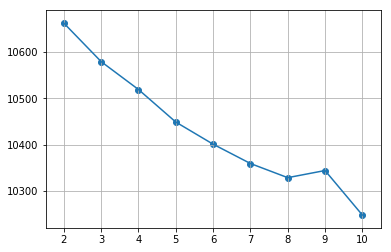

In [221]:
import matplotlib.pyplot as plt
plt.grid()
plt.plot(range(2,11,1),inertia[0:9])
plt.scatter(range(2,11,1),inertia[0:9])

In [160]:
lsa = TruncatedSVD(3)
topic = lsa.fit_transform(tfidfvector)
lsa.explained_variance_ratio_

array([0.00294243, 0.00344267, 0.00293882])

In [161]:
topics.head(1)

,0,1,2,topicid
0,-1.270819e-18,-2.499626e-15,1.136119e-14,2


In [162]:
topics = pd.DataFrame(topic)
topics['topicid'] = topics.values.argmax(1)

In [163]:
topics['topicid'].value_counts()

0    43566
1      622
2      605
Name: topicid, dtype: int64

In [164]:
topic_word_tfidf = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2", 'component_3'],
                          columns = tfidf.get_feature_names())



In [165]:
topic_word_tfidf.head()

,abandon,abandoned,abatement,abbey,abduction,abigail,ability,aboard,abort,abound,...,yesterday,yield,yolk,young,younger,youth,youthful,yuan,zombie,zone
component_1,0.006,0.016,0.0,0.005,0.002,0.004,0.024,0.006,0.0,0.003,...,0.002,0.001,0.0,0.098,0.012,0.009,0.001,0.000,0.025,0.006
component_2,0.000,0.002,-0.0,0.000,-0.001,-0.004,0.007,0.006,0.0,0.002,...,-0.002,0.001,0.0,0.033,-0.011,0.000,-0.001,0.001,-0.016,-0.004
component_3,0.000,0.000,0.0,-0.003,0.001,-0.000,0.009,0.001,0.0,-0.003,...,-0.001,0.000,-0.0,-0.138,-0.009,-0.007,-0.003,-0.000,0.058,0.004


In [166]:
wordcols = topic_word_tfidf.transpose().reset_index()
for col in wordcols[['component_1','component_2', 'component_3']]:
    words = wordcols[['index', col]].sort_values(by = col, ascending = False)
    #print('\nTopic',col, '\n',words[['index',col]].head(20), list(words['index'])[0:20])
    print('\nTopic',col,", ".join(list(words['index'])[0:30]))


Topic component_1 love, man, family, come, magic, dark, young, war, heart, woman, power, death, secret, human, home, father, save, girl, city, dead, vampire, tale, night, mother, together, evil, king, future, turn, earth

Topic component_2 magic, war, king, power, ancient, evil, kingdom, land, earth, fantasy, dragon, queen, battle, dark, magical, epic, empire, city, prince, powerful, adventure, enemy, quest, save, realm, lord, princess, tale, warrior, throne

Topic component_3 vampire, human, dead, blood, demon, hell, earth, undead, killer, city, werewolf, fight, zombie, keep, enemy, kill, race, mate, supernatural, humanity, protect, pack, save, soul, dark, night, survive, death, half, deadly


**Run again to break up topic 1**

In [218]:
info['bookid'] = [int(X) for X in info['bookid']]
info = pd.concat([info.reset_index(), topics['topicid']], axis=1)

In [168]:
info.head()

,index,bookid,description,language,title,text_lemmatized,topicid
0,0,39791289,none,None,Upon Broken Wings,none,0
1,1,23300,eleven year old and have just from to an old m...,eng,"The Door to Time (Ulysses Moore, #1)",eleven year old and have just from to an old m...,0
2,2,12446825,new york times author with the epic conclusion...,eng,"Feversong (Fever, #9)",new york time author with the epic conclusion ...,0
3,3,16091011,what are the of a generation from a park bench...,eng,The Sovereign Soil,what are the of a generation from a park bench...,0
4,4,393147,i as this enthralling epic its climax the youn...,eng,"The Crow (The Books of Pellinor, #3)",i a this enthralling epic it climax the young ...,0


In [222]:
pd.to_pickle(info[['bookid','topicid']], 'book_topics.pkl')

In [169]:
info['text_lemmatized'][info['topicid']==0].head()

0                                                 none
1    eleven year old and have just from to an old m...
2    new york time author with the epic conclusion ...
3    what are the of a generation from a park bench...
4    i a this enthralling epic it climax the young ...
Name: text_lemmatized, dtype: object

In [170]:
tfidf = TfidfVectorizer(stop_words=stopwords)
#X_idf = tfidf.fit_transform(info['description'])
X_idf_2 = tfidf.fit_transform(info['text_lemmatized'][info['topicid']==0])
tfidfvector_2 = pd.DataFrame(X_idf_2.toarray(), columns=tfidf.get_feature_names())
lsa = TruncatedSVD(2)
topic2 = lsa.fit_transform(tfidfvector_2)
lsa.explained_variance_ratio_

array([0.0029662 , 0.00326152])

In [178]:
topics2 = pd.DataFrame(topic2)
topics2['topicid'] = topics2.values.argmax(1)
topics2['topicid'].value_counts()

0    43295
1      271
Name: topicid, dtype: int64

In [171]:
topic_word_tfidf_2 = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2"],
                          columns = tfidf.get_feature_names())

wordcols_2 = topic_word_tfidf_2.transpose().reset_index()
for col in wordcols_2[['component_1','component_2']]:
    words = wordcols_2[['index', col]].sort_values(by = col, ascending = False)
    #print('\nTopic',col, '\n',words[['index',col]].head(20), list(words['index'])[0:20])
    print('\nTopic',col,", ".join(list(words['index'])[0:30]))



Topic component_1 love, man, family, come, dark, heart, young, magic, war, woman, power, death, secret, home, father, human, girl, save, tale, city, dead, night, mother, together, evil, future, turn, friend, earth, face

Topic component_2 love, school, family, girl, town, heart, mother, friend, romance, woman, relationship, night, man, perfect, little, bad, boy, going, husband, sexy, guy, summer, sex, house, right, job, college, hot, good, hard


**Try on 8 topics**

In [223]:
tfidf = TfidfVectorizer(stop_words=stopwords)
#X_idf = tfidf.fit_transform(info['description'])
X_idf_8 = tfidf.fit_transform(info['text_lemmatized'])
tfidfvector_8 = pd.DataFrame(X_idf_8.toarray(), columns=tfidf.get_feature_names())
lsa = TruncatedSVD(8)
topic8 = lsa.fit_transform(tfidfvector_8)
lsa.explained_variance_ratio_

array([0.00294243, 0.00344251, 0.00293962, 0.00269392, 0.00249049,
       0.00243047, 0.00210004, 0.00196394])

In [224]:
topics8 = pd.DataFrame(topic8)
topics8['topicid'] = topics8.values.argmax(1)
topics8['topicid'].value_counts()

0    41506
5     1277
1      552
2      496
7      390
4      222
6      176
3      174
Name: topicid, dtype: int64

# **LDA**

In [12]:
#!python -m spacy download en
import spacy
nlp = spacy.load('en')

In [5]:
info = pd.read_pickle('book_descriptions.pkl')

In [64]:
stopwords = pd.read_pickle('stopwords.pkl')
stopwords.extend(['mac','way','b','p','c','t','book',
                  'novel','author','story','series','rel',
                  'editions','fiction','tale','novel'])


In [72]:
for s in stopwords:
    nlp.Defaults.stop_words.add(s)
    lex = nlp.vocab[s]
    lex.is_stop = True
    nlp.vocab[s].is_stop=True


In [67]:
for s in stopwords:
    nlp.Defaults.stop_words.add(s)

In [75]:
nlp.vocab["rel"].is_stop

True

In [76]:
len(nlp.Defaults.stop_words)

21441

**1. tokenize paragraph; lemmatize; keep only nouns**

In [54]:
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatize_nouns(texts):
    texts_out = []
    allowed_postags=['NOUN']
    for text in texts:
        text_token = w_tokenizer.tokenize(text)
        doc = nlp(' '.join(text_token))
        text_lemma = [w.lemma_ for w in doc if w.pos_ in allowed_postags and w.is_stop == False]
        texts_out.append(text_lemma)
    
    return texts_out

In [77]:
for w in ['this', 'is', 'a', 'story','author']:
    print(nlp.vocab[w].is_stop)

True
True
True
True
True


In [71]:
lemmatize_nouns(['this is a story by an author'])

[[]]

In [78]:
text_clean = lemmatize_nouns(info['description'])

In [33]:
print(len(text_clean), len(info['description']))

44793 44793


In [81]:
pd.to_pickle(text_clean, 'descriptions_cleaned_for_lda.pkl')

In [11]:
text_clean = pd.read_pickle('descriptions_cleaned_for_lda.pkl')

In [35]:
text_clean[1]

['year',
 'mansion',
 'coast',
 'home',
 'world',
 'friend',
 'door',
 'wardrobe',
 'house',
 'door']

In [82]:
for t in text_clean[0:5]:
    print(f'{" ".join(t)} \n')
          

 

mansion coast home friend door house door 

time conclusion pounding fever chaos turn control ally cease death lust love loom earth danger lane sentient body quest power fate man fae song magic fabric earth sidhe heart queen song prince hell fae gain sacrifice pursuit risk victory loss battle soul decision price 

generation park couple catastrophe high student crisis point government interest activity martin family farming depression nation 

epic climax heroine brother gift role dark orphan struggle survival sister destiny city way crow threaten protector orphan girl light resistance vision quest riddle crow riddle beauty darkness battle light 



*corpus has to be updated for new stopwords to take effect*

In [12]:
id2word = gensim.corpora.Dictionary(text_clean)

corpus = [id2word.doc2bow(t) for t in text_clean]

In [364]:
#[(id2word[id], freq) for id, freq in corpus[1]]

[('coast', 1),
 ('door', 2),
 ('friend', 1),
 ('home', 1),
 ('house', 1),
 ('mansion', 1),
 ('wardrobe', 1),
 ('world', 1),
 ('year', 1)]

**With 8 topics**

In [84]:
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=128,
                                           per_word_topics=True)

In [85]:
pd.to_pickle(lda_model,'lda_model.pkl')

In [86]:
lda_model.print_topics(num_words=20)

[(0,
  '0.030*"school" + 0.021*"girl" + 0.019*"love" + 0.014*"friend" + 0.010*"boy" + 0.010*"romance" + 0.010*"night" + 0.008*"sex" + 0.008*"college" + 0.008*"guy" + 0.007*"job" + 0.007*"town" + 0.006*"heart" + 0.006*"adult" + 0.006*"student" + 0.006*"relationship" + 0.006*"chance" + 0.006*"dream" + 0.006*"jane" + 0.005*"class"'),
 (1,
  '0.050*"family" + 0.033*"mother" + 0.031*"father" + 0.025*"house" + 0.020*"town" + 0.019*"home" + 0.014*"girl" + 0.014*"boy" + 0.010*"son" + 0.010*"sister" + 0.009*"brother" + 0.009*"summer" + 0.008*"daughter" + 0.008*"sea" + 0.008*"secret" + 0.007*"mystery" + 0.007*"truth" + 0.007*"village" + 0.007*"death" + 0.006*"friend"'),
 (2,
  '0.078*"vampire" + 0.031*"fairy" + 0.031*"jack" + 0.025*"blood" + 0.018*"werewolf" + 0.017*"night" + 0.016*"moon" + 0.016*"tale" + 0.016*"pack" + 0.016*"mate" + 0.015*"alpha" + 0.012*"volume" + 0.009*"novella" + 0.009*"witch" + 0.009*"human" + 0.008*"tree" + 0.008*"romance" + 0.008*"male" + 0.007*"midnight" + 0.007*"shop"'

In [37]:
topic_dict = {0:'young adult romance',
              1:'young adult adventure',
              2:'supernatural romance',
              3:'sci-fi',
              4:'urban apocalypse',
              5:'fairytale',
              6:'epic battle',
              7:'sci-fi dystopia'
             }

**Try with only 5 categories**

In [87]:
lda_model_5 = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=128,
                                           per_word_topics=True)

In [91]:
pd.to_pickle(lda_model_5,'lda_model_5.pkl')

In [5]:
lda_model_5=pd.read_pickle('lda_model_5.pkl')

In [50]:
np.array(corpus[10]).T

array([[  6,  78,  95, 109, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143],
       [  2,   1,   1,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1]])

In [47]:
from gensim.similarities import MatrixSimilarity, SparseMatrixSimilarity, Similarity
from gensim.matutils import softcossim
from gensim import corpora

id2word = gensim.corpora.Dictionary(text_clean)
corpus = [id2word.doc2bow(t) for t in text_clean]
lsi = gensim.models.LsiModel(corpus, id2word=dictionary, num_topics=5)
vec_bow = text_clean[10]
vec_lsi = lsi[vec_bow]
#index = MatrixSimilarity(lda_model_5[corpus])



ValueError: too many values to unpack (expected 2)

In [88]:
lda_model_5.print_topics(num_words=20)

[(0,
  '0.036*"love" + 0.024*"family" + 0.020*"man" + 0.017*"girl" + 0.016*"woman" + 0.015*"heart" + 0.015*"mother" + 0.015*"school" + 0.012*"father" + 0.012*"night" + 0.011*"friend" + 0.010*"town" + 0.009*"boy" + 0.009*"romance" + 0.009*"house" + 0.008*"home" + 0.007*"sister" + 0.007*"husband" + 0.006*"relationship" + 0.006*"brother"'),
 (1,
  '0.030*"magic" + 0.022*"king" + 0.015*"land" + 0.013*"fantasy" + 0.013*"prince" + 0.013*"queen" + 0.011*"dragon" + 0.011*"adventure" + 0.011*"father" + 0.011*"power" + 0.010*"kingdom" + 0.009*"fairy" + 0.009*"princess" + 0.009*"city" + 0.008*"quest" + 0.007*"witch" + 0.007*"sea" + 0.007*"lord" + 0.006*"journey" + 0.006*"son"'),
 (2,
  '0.022*"war" + 0.020*"vampire" + 0.019*"man" + 0.016*"power" + 0.014*"blood" + 0.013*"death" + 0.012*"battle" + 0.012*"heart" + 0.011*"enemy" + 0.011*"love" + 0.010*"soul" + 0.010*"woman" + 0.009*"darkness" + 0.009*"demon" + 0.009*"fate" + 0.008*"earth" + 0.008*"evil" + 0.008*"hell" + 0.008*"warrior" + 0.007*"order

In [90]:
topic_dict = {0:'young adult',
              1:'epic fantasy/fairytale',
              2:'supernatural',
              3:'sci-fi',
              4:'zombie-apocalypse/urban fantasy'
             }

**Explore topic output**

In [92]:
text_clean = pd.read_pickle('descriptions_cleaned_for_lda.pkl')
lda_model = pd.read_pickle('lda_model_5.pkl')

In [19]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
top_topics = lda_model.get_document_topics(corpus[0])
top_topics.sort(key=lambda x: x[1], reverse=True)

print(top_topics)

[(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)]


In [94]:
len(corpus)

44793

In [95]:
get_document_topics = [lda_model.get_document_topics(item) for item in corpus]


In [370]:
get_document_topics[0:10]

[[(0, 0.1),
  (1, 0.1),
  (2, 0.1),
  (3, 0.1),
  (4, 0.1),
  (5, 0.1),
  (6, 0.1),
  (7, 0.1),
  (8, 0.1),
  (9, 0.1)],
 [(0, 0.4510861), (2, 0.2400264), (3, 0.09981296), (4, 0.15450868)],
 [(0, 0.15648113), (6, 0.44100744), (8, 0.072670355), (9, 0.31851366)],
 [(2, 0.13557108), (5, 0.7838431), (7, 0.05256505)],
 [(2, 0.19199394),
  (5, 0.047501437),
  (6, 0.12508051),
  (7, 0.24163829),
  (9, 0.37987778)],
 [(0, 0.5986209), (6, 0.06655079), (9, 0.29592144)],
 [(3, 0.09790961), (5, 0.13908531), (7, 0.1328346), (9, 0.59262353)],
 [(0, 0.25659186), (4, 0.30271628), (5, 0.094294235), (9, 0.30638397)],
 [(0, 0.20490415),
  (2, 0.18328841),
  (5, 0.04065954),
  (6, 0.19325207),
  (7, 0.134553),
  (9, 0.22852255)],
 [(0, 0.12288656), (6, 0.5006673), (7, 0.14785382), (9, 0.20249543)]]

In [96]:
from operator import itemgetter
topics_dict = {}
for i, doc in enumerate(get_document_topics):
    topics_dict[i] = max(doc,key=itemgetter(1))[0]
main_topic = pd.DataFrame(list(topics_dict.items()), columns = ['index','topic'])
main_topic.topic.value_counts()

0    16661
2     9985
1     7180
4     6597
3     4370
Name: topic, dtype: int64

In [97]:
main_topic.head()

,index,topic
0,0,0
1,1,0
2,2,2
3,3,4
4,4,2


In [98]:
topics_df = pd.DataFrame(get_document_topics)
topics_df.head()

,0,1,2,3,4
0,"(0, 0.2)","(1, 0.2)","(2, 0.2)","(3, 0.2)","(4, 0.2)"
1,"(0, 0.8996268)","(1, 0.02526354)","(2, 0.025050567)","(3, 0.025001353)","(4, 0.025057727)"
2,"(0, 0.043767158)","(1, 0.27349612)","(2, 0.6737738)",None,None
3,"(0, 0.27277043)","(1, 0.011855935)","(2, 0.0118493335)","(3, 0.08132066)","(4, 0.6222036)"
4,"(1, 0.31698543)","(2, 0.6633459)",None,None,None


In [99]:
print(len(info),len(topics_df), len(main_topic), len(text_clean))

44793 44793 44793 44793


In [100]:
pd.Series(text_clean[0:5])

0                                                   []
1    [mansion, coast, home, friend, door, house, door]
2    [time, conclusion, pounding, fever, chaos, tur...
3    [generation, park, couple, catastrophe, high, ...
4    [epic, climax, heroine, brother, gift, role, d...
dtype: object

In [130]:
final_topics = pd.concat([info.reset_index(), #basic book info
                          pd.Series(text_clean), #description to give topic None when []
                          topics_df, #column w topic weights                       
                          main_topic], axis=1) #topic number w most common topic


In [131]:
final_topics['topic_name'] = final_topics['topic'].map(topic_dict)

In [132]:
final_topics.columns = ["index", "bookid",
                        'description',
                        'language', 'title',
                        'text_clean', 'topic_1',
                        'topic_2', 'topic_3',
                        'topic_4','topic_5',
                        'index2' , 'topic', 'topic_name'
                       ]
final_topics = final_topics.drop('index', axis=1)
final_topics = final_topics.drop('index2', axis=1)
final_topics['text_clean']=[str(X) for X in final_topics['text_clean']]
final_topics.loc[final_topics['text_clean']=='[]', 'topic_name'] = 'None'

In [138]:
final_topics.tail()

,bookid,description,language,title,text_clean,topic_1,topic_2,topic_3,topic_4,topic_5,topic,topic_name
44788,28271616,none,eng,Zombie Off: The Beginning,[],"(0, 0.2)","(1, 0.2)","(2, 0.2)","(3, 0.2)","(4, 0.2)",0,None
44789,6634409,it ’ s been one year since ex navy seal kelly ...,eng,"The Darkest Hour (KGI, #1)","['navy', 'seal', 'wife', 'grief', 'guilt', 'hu...","(0, 0.42655742)","(1, 0.012173917)","(2, 0.09417888)","(3, 0.09606156)","(4, 0.37102824)",0,young adult
44790,22043009,a new dark fantasy from new york times jean “ ...,eng,"King's (The King Trilogy, #1)","['fantasy', 'time', 'man', 'price', 'price', '...","(0, 0.57013726)","(1, 0.014904489)","(2, 0.21001387)","(3, 0.19042715)","(4, 0.014517208)",0,young adult
44791,530174,medalist a most unlikely hero in this compelli...,eng,Perloo The Bold,"['hero', 'fantasy', 'look', 'member', 'rabbit'...","(0, 0.013439839)","(1, 0.17033197)","(2, 0.31541315)","(3, 0.4872559)","(4, 0.013559146)",3,sci-fi
44792,42768338,from author comes her deeply personal memoir o...,None,Busted: A Memoir of Teenage Years,"['memoir', 'pain', 'hardship', 'humor', 'scour...","(0, 0.7084295)","(1, 0.01834708)","(2, 0.12688123)","(3, 0.018614419)","(4, 0.12772769)",0,young adult


In [137]:
pd.to_pickle(final_topics,'final_book_topics.pkl')

In [4]:
topics = pd.read_pickle('final_book_topics.pkl')

**Name topics and run EDA and add user topics to Flask**

In [139]:
final_topics.topic_name.value_counts()

young adult                        13744
supernatural                        9985
epic fantasy/fairytale              7180
zombie-apocalypse/urban fantasy     6597
sci-fi                              4370
None                                2917
Name: topic_name, dtype: int64

***